In [189]:
import sys
sys.path.append("..")
from tools.linear_regression.linear_regression import get_column, LinReg, correlation, dot
import pandas as pd
import os
import matplotlib.pyplot as plt
import math


## Load and Prepare Dataset
source: https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv

In [190]:
dir_path = os.path.abspath('')
source = os.path.join(dir_path, 'data', 'Cars', 'car_details.csv')
df = pd.read_csv(source)


#### Remve units and change 'fields' dtype to float

In [191]:
def replace_convert(value, unit='', *args, **kwargs):
    if type(value) == str:
        if unit in value:
            value = value.replace(unit, '').strip()
            try:
                return float(value)
            except:
                return 0.0
        else:
            return float(value)
    else:
        return value        

def mileage(value):
    # 1 liter mean(LPG, gas) = approx. 730gr - thus, e.g., 730gr * 1.37 = 1,000.1
    if type(value) == str:
        if 'kmpl' in value:
            return float(value.replace('kmpl', '').strip())
        elif 'km/kg' in value:
            return float(value.replace('km/kg', '').strip()) * 1.37     
    else:
        return value



In [192]:
df['engine'] = df['engine'].apply(replace_convert, unit='CC')
df['max_power'] = df['max_power'].apply(replace_convert, unit='bhp')
df['mileage'] = df['mileage'].apply(mileage)

#### reduce magnitude of km_driven

In [193]:
df['km_driven'] = df['km_driven'].apply(lambda x: x/1000)


In [194]:
# util function that was run to determine levels of some variables
counts = {}
def count(value, counts):
    if type(value) == str:
        value = value.replace(' ', '_')
    if value in counts.keys():
        counts[value] += 1
    else: 
        counts[value] = 1
# results

#fuel = {'Diesel': 4402, 'Petrol': 3631, 'LPG': 38, 'CNG': 57}
#seller_type = {'Individual': 6766, 'Dealer': 1126, 'Trustmark_Dealer': 236}
#transmission = {'Manual': 7078, 'Automatic': 1050}
#owner = {'First_Owner': 5289, 'Second_Owner': 2105, 'Third_Owner': 555, 'Fourth_&_Above_Owner': 174, 'Test_Drive_Car': 5}

In [195]:
# util function to sort datapoints
def order(x,y, desc=False):
    data = list(zip(x,y))
    data.sort(key=lambda i:i[0],reverse=desc)
    return [d[0] for d in data], [d[1] for d in data]

#### Convert categoricals to numericals

In [196]:
def numerical_fuel(value):
    if value == 'Diesel':
        return 0
    elif value == 'Petrol':
        return 1
    elif value == 'LPG' or value == 'CNG': 
        return 2
    else:
        return 2

def nummerical_seller(value):
    if value == 'Dealer' or value == 'Trustmark Dealer':
        return 1
    elif value == 'Individual':
        return 0
    else: 
        return 1

def numerical_trans(value):
    if value == 'Manual':
        return 0
    elif value == 'Automatic':
        return 1
    else:
        return 1
        

def numerical_owner(value):
    if value == 'First Owner':
        return 0
    elif value == 'Second Owner':
        return 1
    elif value == 'Third Owner':
        return 2
    elif value == 'Fourth & Above Owner':
        return 3
    elif value == 'Test_Drive_Car':
        return 4
    else:
        return 4



In [197]:
categorical = [('fuel', numerical_fuel), ('seller_type', nummerical_seller), ('transmission', numerical_trans), ('owner', numerical_owner)]
for col, func in categorical:
    df[col] = df[col].apply(func)

#### convert selling price
 no explanation in the dataset, but since the source is CarDheko, based in India and prices are indicated in LAKH, it is assumedthat the prices in the dataset are INR, because the mean is at 638000, which would equal 63,800,000,000 INR if converted from LAKH
 
100,000 INR equals 1342.73 USD (mid-market exchange rate at 10:45 UTC, Nov 3, 2021) will result in using a conversion rate of 74.5 (INR to USD) example selling_price: 290000 INR;  3,892.62 USD

In [198]:
def convert_to_USD(value):
    return value/74.5


In [199]:
df['selling_price'] = df['selling_price'].apply(convert_to_USD)

Model_1 (see further below) had an unusual high coefficient for stick cars (as opposed to automatic transmission), skewed count as well as tremendous differences in mean manual_mean_price = 25111USD vs. automatic_mean_price = 6113USD

Thus, it seems that this dataset suggests the notion that automatic cars are generally sold at a higher price.

In [200]:
manuals = df[df['transmission'] == 1]
print(manuals['selling_price'].describe())
automatics = df[df['transmission'] == 0]
print(automatics['selling_price'].describe())

count      1050.000000
mean      25111.779917
std       22020.577786
min        1006.711409
25%        8657.718121
50%       14765.100671
75%       36389.261745
max      134228.187919
Name: selling_price, dtype: float64
count     7078.000000
mean      6113.098852
std       3998.191060
min        402.671141
25%       3221.476510
50%       5369.127517
75%       8053.691275
max      42953.020134
Name: selling_price, dtype: float64


#### selling_price to python list to use as target variable/y in custom code

In [201]:
target = df['selling_price'].tolist()

#### change year to age (2021 - year) --> last update of dataset was 2020 -> conversion in order to make interpretation a little easier (note: took 2021 to avoid zeroDivision or similar crooks)

In [202]:
def year_to_age(value):
        return 2021 - value
    

In [203]:
    df['age'] = df['year'].apply(year_to_age)

#### drop unwanted columns 
name is irrelevant, torque seems irrelevant as max_power is there (at early state), selling_price is used as target, year got changed to age

In [204]:
df.drop(labels=['selling_price', 'name', 'torque', 'year'], axis=1, inplace=True)

#### replace nan with mean vals

In [205]:
for col in df.columns:
    df[col].fillna(value=df[col].mean(), inplace=True)

#### create python list of x variables

In [206]:
x_vars = df.values.tolist()

#### prepare columns

In [207]:
tar_label = ['selling_price']
cols = [*tar_label, *df.columns]

## Get Feel for Data

##### visualize individual variables in relation to target

In [208]:
df.head()

,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age
0,145.5,0,0,0,0,23.40,1248.0,74.00,5.0,7
1,120.0,0,0,0,1,21.14,1498.0,103.52,5.0,7
2,140.0,1,0,0,2,17.70,1497.0,78.00,5.0,15
3,127.0,0,0,0,0,23.00,1396.0,90.00,5.0,11
4,120.0,1,0,0,0,16.10,1298.0,88.20,5.0,14


In [209]:
print(target[:5])

[6040.268456375839, 4966.442953020134, 2120.8053691275168, 3020.1342281879197, 1744.96644295302]


In [210]:
def plot_vars(x,y,labels=('', ''), save=False):
    plt.scatter(x,y)
    plt.xlabel(labels[1])
    plt.ylabel(labels[0])
    plt.title(labels[0] + ' vs ' + labels[1])
    if save:
        plt.savefig(f'results/Cars/{labels[0]}.png')
    plt.show()

def plot_with_line(x, y, regression, labels=('', ''), save=False):
    plt.scatter(x, y)
    plt.xlabel(labels[1])
    plt.ylabel(labels[0])
    plt.title(labels[0] + ' vs ' + labels[1])
    y_hat = [dot(xi, regression.beta) for xi in regression.x]
    x_sort, y_sort = order(x, y_hat)
    plt.plot(x_sort, y_sort, color='red')
    if save:
        plt.savefig(f'results/Cars/{labels[0]}.png')
    plt.show()


### single variables variations

##### price and year

In [211]:
def fit_line_lin(xi, beta):
    return beta[0] + beta[1]*xi

In [212]:
idx = cols.index('age') -1
age = get_column(x_vars, idx)
age_2 = [i**2 for i in age]
one_over_age = [1/i for i in age]
age_ln = [math.log(i) for i in age]

target_ln = [math.log(i) for i in target]

a) age not tempered with

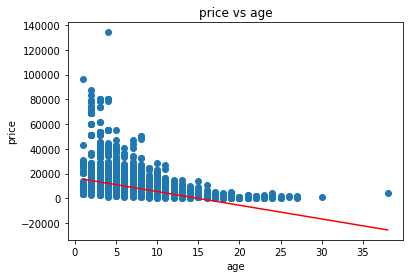

In [213]:
age_std = LinReg(age, target, columns=['price', 'age'])
age_std.fit()
plot_with_line(x=age, y=target, regression=age_std, labels=['price', 'age'])


b) age_2

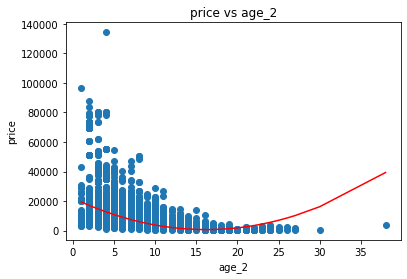

In [214]:
#create new x_vars age and age_2
age_super = [[i, j] for i,j in list(zip(age, age_2))]

age_sqr = LinReg(age_super, target, columns=['price', 'age', 'age_2'])
age_sqr.fit()
plot_with_line(x=age, y=target, regression=age_sqr, labels=['price', 'age_2'])

c) age_2 and ln_price

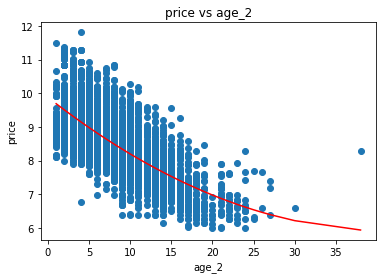

In [215]:
age_sqr_price_ln = LinReg(age_super, target_ln, columns=['price', 'age', 'age_2'])
age_sqr_price_ln.fit()
plot_with_line(x=age, y=target_ln, regression=age_sqr_price_ln, labels=['price', 'age_2'])

d) inverse of age

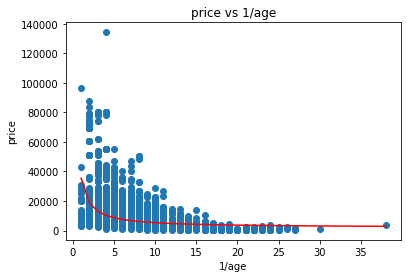

In [216]:
over_age = LinReg(one_over_age, target, columns=['price', '1/age'])
over_age.fit()
plot_with_line(x=age, y=target, regression=over_age, labels=['price', '1/age'])

e) ln of age

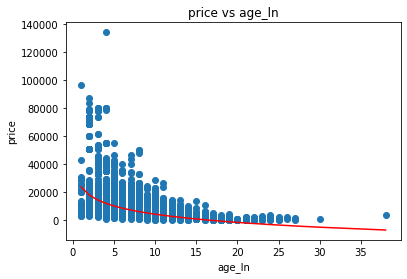

In [217]:
ln_of_age = LinReg(age_ln, target, columns=['price', 'age_ln'])
ln_of_age.fit()
plot_with_line(x=age, y=target, regression=ln_of_age, labels=['price', 'age_ln'])

##### check frequency distribution of price and age

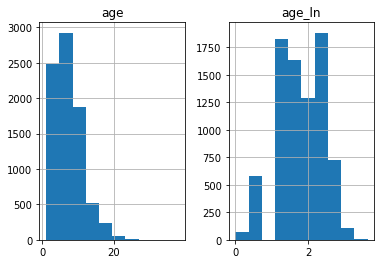

In [218]:
df1 = pd.DataFrame({'age': age})
df2 = pd.DataFrame({'age_ln': age_ln})
fig, ax = plt.subplots(1, 2)
df1.hist('age', ax=ax[0])
df2.hist('age_ln', ax=ax[1])
plt.show()


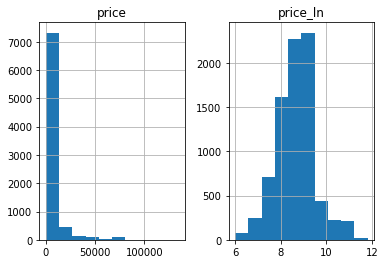

In [219]:
df1 = pd.DataFrame({'price': target})
df2 = pd.DataFrame({'price_ln': target_ln})
fig, ax = plt.subplots(1, 2)
df1.hist('price', ax=ax[0])
df2.hist('price_ln', ax=ax[1])
plt.show()

f) target and age as ln 

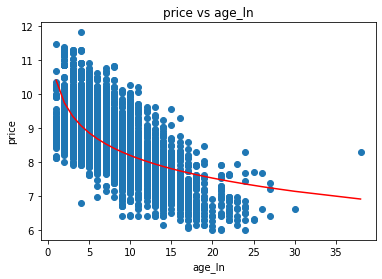

In [220]:
ln_price_age = LinReg(age_ln, target_ln, columns=['price_ln', 'age_ln'])
ln_price_age.fit()
plot_with_line(x=age, y=target_ln, regression=ln_price_age, labels=['price', 'age_ln'])

Attemp at interpretations: a 1% increase in age, decreases the price by 0.95%, all else equal 
            Q: what is a 1% increase?
            A: age of car = 1, 1% increase = 1*1.1 = 1.1 yrs of age
                --> if price of car A, age 1yr = 200$, then price of car B, age 1.1yr =                         198.1 --> seems reasonable
                --> car_1: price = 6040USD, age = 6 years, car_2: price = ?, age = 8 year;
                

In [221]:
math.exp(ln_price_age.predict([1, math.log(8)]))

4464.778145545667

##### price vs km_driven

In [222]:
km = [i[0] for i in x_vars]
one_over_km = [1/i for i in km]
km_ln = [math.log(i) for i in km]

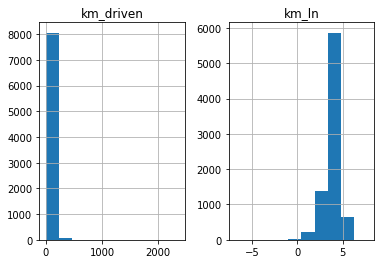

In [223]:
df1 = pd.DataFrame({'km_driven': km})
df2 = pd.DataFrame({'km_ln': km_ln})
fig, ax = plt.subplots(1, 2)
df1.hist('km_driven', ax=ax[0])
df2.hist('km_ln', ax=ax[1])
plt.show()

a) km vs price

In [224]:
l = ['price', 'km']
lo = ['price', 'one_over_km']
lln = ['price', 'km_ln']
llnpln = ['price_ln', 'km_1']

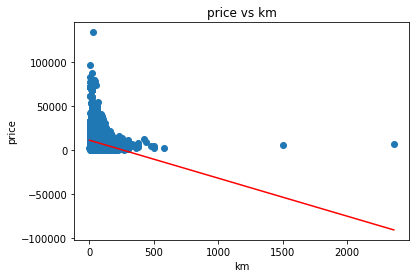

In [225]:
km_price = LinReg(km, target, columns=l)
km_price.fit()
plot_with_line(x=km, y=target, regression=km_price, labels=l)

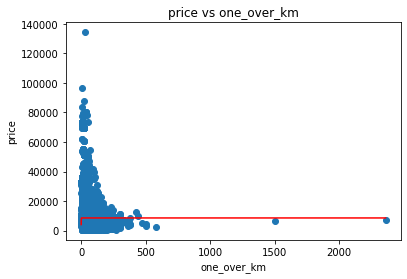

In [226]:
one_over = LinReg(one_over_km, target, columns=lo)
one_over.fit()
plot_with_line(x=km, y=target, regression=one_over, labels=lo)

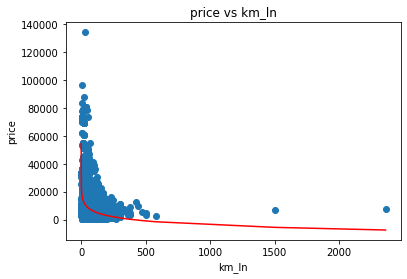

In [227]:
km_ln_reg = LinReg(km_ln, target, columns=lln)
km_ln_reg.fit()
plot_with_line(x=km, y=target, regression=km_ln_reg, labels=lln)


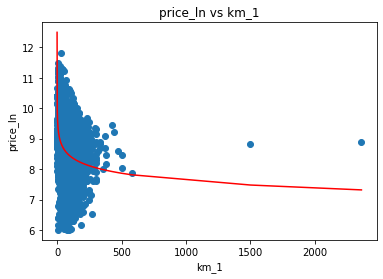

In [228]:
km_ln_pln = LinReg(km_ln, target_ln, columns=lln)
km_ln_pln.fit()
plot_with_line(x=km, y=target_ln, regression=km_ln_pln, labels=llnpln)

#### remove km_driven outlier

In [229]:
km_idx = cols.index('km_driven') -1
km_col = get_column(x_vars, km_idx)
km_col_copy = km_col.copy()
km_col_copy.sort(reverse=True)
max_vals = km_col_copy[:2]
for i in max_vals:
    pass


    



#### MODEL_1: target: price; vars: age, km_driven, transmission (bin), fuel (3 cats)

In [230]:
df.head()

,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age
0,145.5,0,0,0,0,23.40,1248.0,74.00,5.0,7
1,120.0,0,0,0,1,21.14,1498.0,103.52,5.0,7
2,140.0,1,0,0,2,17.70,1497.0,78.00,5.0,15
3,127.0,0,0,0,0,23.00,1396.0,90.00,5.0,11
4,120.0,1,0,0,0,16.10,1298.0,88.20,5.0,14


In [231]:
idx_age = cols.index('age') -1
idx_km_driven = cols.index('km_driven') -1
idx_trans = cols.index('transmission') -1
idx_fuel = cols.index('fuel')-1

explanatory_m1 = [[i[idx_age], i[idx_km_driven], i[idx_trans], i[idx_fuel]] for i in x_vars]
col_labels = ['selling_price', 'age', 'km_driven', 'transmission', 'fuel']


In [232]:
#create model 
model_1 = LinReg(explanatory_m1, target, columns=col_labels)

In [233]:
#change fuel to dummy set
fuel_col = get_column(explanatory_m1, 4)
fuel_col = [int(i) for i in fuel_col]

print(set(fuel_col))

model_1.make_dummy(fuel_col, 'fuel', 'fuel')
model_1.drop_var(['d_fuel_cat_1'])


{0, 1, 2}


[[1.0, 7.0, 145.5, 0.0, 0, 0],
 [1.0, 7.0, 120.0, 0.0, 0, 0],
 [1.0, 15.0, 140.0, 0.0, 1, 0],
 [1.0, 11.0, 127.0, 0.0, 0, 0],
 [1.0, 14.0, 120.0, 0.0, 1, 0],
 [1.0, 4.0, 45.0, 0.0, 1, 0],
 [1.0, 14.0, 175.0, 0.0, 0, 1],
 [1.0, 20.0, 5.0, 0.0, 1, 0],
 [1.0, 10.0, 90.0, 0.0, 0, 0],
 [1.0, 8.0, 169.0, 0.0, 0, 0],
 [1.0, 7.0, 68.0, 0.0, 0, 0],
 [1.0, 16.0, 100.0, 0.0, 1, 0],
 [1.0, 12.0, 140.0, 0.0, 0, 0],
 [1.0, 14.0, 80.0, 0.0, 1, 0],
 [1.0, 12.0, 90.0, 0.0, 1, 0],
 [1.0, 5.0, 40.0, 0.0, 1, 0],
 [1.0, 5.0, 70.0, 0.0, 0, 0],
 [1.0, 9.0, 53.0, 0.0, 0, 0],
 [1.0, 19.0, 80.0, 0.0, 1, 0],
 [1.0, 5.0, 100.0, 0.0, 0, 0],
 [1.0, 10.0, 100.0, 0.0, 0, 0],
 [1.0, 4.0, 50.0, 0.0, 0, 0],
 [1.0, 6.0, 40.0, 0.0, 0, 0],
 [1.0, 9.0, 72.0, 0.0, 0, 0],
 [1.0, 3.0, 35.0, 0.0, 1, 0],
 [1.0, 5.0, 45.0, 0.0, 1, 0],
 [1.0, 4.0, 28.0, 0.0, 1, 0],
 [1.0, 8.0, 70.0, 0.0, 0, 0],
 [1.0, 12.0, 120.0, 0.0, 1, 0],
 [1.0, 3.0, 25.0, 0.0, 1, 0],
 [1.0, 4.0, 70.0, 0.0, 0, 0],
 [1.0, 18.0, 50.0, 0.0, 1, 0],
 [1.0, 9.0, 35.

In [234]:
model_1.fit()

[14415.281403055984,
 -645.5474335770298,
 -15.58785776615287,
 16764.09228699972,
 -4991.657410146188,
 -4270.418296579659]

In [235]:
model_1.analyse()



 09/01/2022 15:44:21
|--------------------|-------------------|
|REGRESSION STATS    |                   |
|========================================|
|R Square            |0.47132345988974145|
|--------------------|-------------------|
|Adj R Square        |0.4712584000152509 |
|--------------------|-------------------|
|Multiple R          |0.6865300138302342 |
|--------------------|-------------------|
|Std Error Regression|7869.316788060393  |
|--------------------|-------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|------------------|------------------|
|ANOVA     |DF   |SS                |MS                |
|======================================================|
|Regression|5    |448621303898.0523 |74770217316.34206 |
|----------|-----|------------------|------------------|
|Residual  |8122 |503211868172.36017|61956644.690022185|
|----------|-----|------------------|------------------|
|Total     |8127 |95183317

({'regression': {'df': 5,
   'sum_squares': 448621303898.0523,
   'mean_squares': 89724260779.61046,
   'tup': (5, 448621303898.0523, 74770217316.34206)},
  'residual': {'df': 8122,
   'sum_squares': 503211868172.36017,
   'mean_squares': 61964273.87912328,
   'tup': (8122, 503211868172.36017, 61956644.690022185)},
  'total': {'df': 8127,
   'sum_squares': 951833172070.4164,
   'mean_squares': 117119868.59485866,
   'tup': (8127, 951833172070.4164, 117119868.59485866)},
  'regression_f': {'regression_f': 1447.9998741636177}},
 {'r_square': 0.47132345988974145,
  'adj_r_square': 0.4712584000152509,
  'multiple_r': 0.6865300138302342,
  'std_error_regression': 7869.316788060393},
 {'values': [['selling_price',
    'Coefficients',
    'SE',
    'T-Stat',
    'P-Value',
    'Lower 95.0%',
    'Upper 95.0%'],
   ['_const',
    14415.281403055984,
    368.46644431486675,
    39.12237226882362,
    0.0,
    13692.992792099698,
    15137.57001401227],
   ['age',
    -645.5474335770298,
    35.

#### Model 2 - ln(price) = ln(age), ln(km_driven), trans (bin), fuel (3 cats)

Reinstating Variables






In [236]:
price_ln = [math.log(i) for i in target]

idx_age = cols.index('age') -1
age = get_column(x_vars, idx_age)
age_ln = [math.log(i) for i in age]

idx_km_driven = cols.index('km_driven') -1
km_driven = get_column(x_vars, idx_km_driven)
km_driven_ln = [math.log(i) for i in km_driven]



idx_trans = cols.index('transmission') -1
idx_fuel = cols.index('fuel')-1

transmis = get_column(x_vars, idx_trans)
fueltype = get_column(x_vars, idx_fuel)





combined = zip(age_ln, km_driven_ln, transmis, fueltype)

explanatory_m2 = [[a,b,c,d] for a,b,c,d in combined]
col_labels = ['selling_price_ln', 'age_ln', 'km_driven_ln', 'transmission', 'fuel']


model_2 = LinReg(explanatory_m2, price_ln, col_labels)



#change fuel to dummy set
fuel_col_ = get_column(explanatory_m2, 4)
fuel_col_ = [int(i) for i in fuel_col]

model_2.make_dummy(fuel_col_, 'fuel', 'fuel')
model_2.drop_var(['d_fuel_cat_1'])


[[1.0, 1.9459101490553132, 4.980176086611547, 0.0, 0, 0],
 [1.0, 1.9459101490553132, 4.787491742782046, 0.0, 0, 0],
 [1.0, 2.70805020110221, 4.941642422609304, 0.0, 1, 0],
 [1.0, 2.3978952727983707, 4.844187086458591, 0.0, 0, 0],
 [1.0, 2.6390573296152584, 4.787491742782046, 0.0, 1, 0],
 [1.0, 1.3862943611198906, 3.8066624897703196, 0.0, 1, 0],
 [1.0, 2.6390573296152584, 5.1647859739235145, 0.0, 0, 1],
 [1.0, 2.995732273553991, 1.6094379124341003, 0.0, 1, 0],
 [1.0, 2.302585092994046, 4.499809670330265, 0.0, 0, 0],
 [1.0, 2.0794415416798357, 5.1298987149230735, 0.0, 0, 0],
 [1.0, 1.9459101490553132, 4.219507705176107, 0.0, 0, 0],
 [1.0, 2.772588722239781, 4.605170185988092, 0.0, 1, 0],
 [1.0, 2.4849066497880004, 4.941642422609304, 0.0, 0, 0],
 [1.0, 2.6390573296152584, 4.382026634673881, 0.0, 1, 0],
 [1.0, 2.4849066497880004, 4.499809670330265, 0.0, 1, 0],
 [1.0, 1.6094379124341003, 3.6888794541139363, 0.0, 1, 0],
 [1.0, 1.6094379124341003, 4.248495242049359, 0.0, 0, 0],
 [1.0, 2.19722

In [237]:
model_2.fit()

[10.308402433157397,
 -0.8361050220729727,
 0.006439222020613353,
 0.8252573315352967,
 -0.5747429347945007,
 -0.665226411417672]

In [238]:
model_2.analyse()



 09/01/2022 15:45:03
|--------------------|-------------------|
|REGRESSION STATS    |                   |
|========================================|
|R Square            |0.6765280780312379 |
|--------------------|-------------------|
|Adj R Square        |0.6764882710017069 |
|--------------------|-------------------|
|Multiple R          |0.8225132692128668 |
|--------------------|-------------------|
|Std Error Regression|0.47728331998948553|
|--------------------|-------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|------------------|-------------------|
|ANOVA     |DF   |SS                |MS                 |
|=======================================================|
|Regression|5    |3871.4938068591628|645.2489678098605  |
|----------|-----|------------------|-------------------|
|Residual  |8122 |1851.0976606315483|0.22791155634468704|
|----------|-----|------------------|-------------------|
|Total     |8127 |5

({'regression': {'df': 5,
   'sum_squares': 3871.4938068591628,
   'mean_squares': 774.2987613718326,
   'tup': (5, 3871.4938068591628, 645.2489678098605)},
  'residual': {'df': 8122,
   'sum_squares': 1851.0976606315483,
   'mean_squares': 0.22793962081412983,
   'tup': (8122, 1851.0976606315483, 0.22791155634468704)},
  'total': {'df': 8127,
   'sum_squares': 5722.591467491606,
   'mean_squares': 0.7041456216920888,
   'tup': (8127, 5722.591467491606, 0.7041456216920888)},
  'regression_f': {'regression_f': 3396.94678181124}},
 {'r_square': 0.6765280780312379,
  'adj_r_square': 0.6764882710017069,
  'multiple_r': 0.8225132692128668,
  'std_error_regression': 0.47728331998948553},
 {'values': [['selling_price_ln',
    'Coefficients',
    'SE',
    'T-Stat',
    'P-Value',
    'Lower 95.0%',
    'Upper 95.0%'],
   ['_const',
    10.308402433157397,
    0.030559386826412186,
    337.32360180237464,
    0.0,
    10.248498207404717,
    10.368306658910077],
   ['age_ln',
    -0.8361050220

#### It seems that ln_km_driven does not have any major influence on the pricing prediction, the r2 score is suboptimal.


## what follows is my car yanked through the predictor

Age: 10 years
km_driven: 129.00
transmission: 0
fuel: 1,0 (petrol)


In [239]:
features = [1, math.log(10), math.log(129), 0, 1, 0]

my_car = model_2.predict(features)
print(my_car)


7.839749949410428


In [240]:
print(f'I could sell my car in India in 2020/2021 for {math.exp(my_car)} USD')

I could sell my car in India in 2020/2021 for 2539.569733517409 USD


## Now, lett's run the same with scikitlearn